In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller

### Load Data

In [2]:
df = pd.read_csv("in_index.csv")
df['Dates']  = pd.to_datetime(df['Dates'])
print(df.shape)
df.tail(2)

(429, 22)


,Dates,NAPMPMI Index,Initial Jobless Claims,Non Farm Payroll,Labor Force Participation Index,University of Michigan Confidence,GDP QOQ Index,FEDL01 Index,Diff_2_10,SP_price,...,HS,Gold_price,Gold,FTSE_price,FTSE,DJ_price,DJ,AGG_price,AGG,diff_10_2
427,2019-07-31,51.2,217,166,63.0,98.4,2.0,2.40,0.06,2980.38,...,-0.026797,1427.55,0.013165,7586.78,0.021702,26864.27,0.009936,2176.49,0.002201,0.06
428,2019-08-31,49.1,219,219,63.2,89.8,2.0,2.13,0.05,2926.46,...,-0.073909,1528.40,0.070646,7207.18,-0.050034,26403.28,-0.017160,2232.89,0.025913,0.05


### All recessions based on FRED definition

In [3]:
from pandas_datareader.data import DataReader
from datetime import datetime
usrec = DataReader('USREC', 'fred', start=datetime(1910, 1, 1), end=datetime(2019, 9, 1))
usrec

,USREC
DATE,
1910-01-01,0
1910-02-01,1
1910-03-01,1
1910-04-01,1
1910-05-01,1
...,...
2019-05-01,0
2019-06-01,0
2019-07-01,0


### Functions Used 

In [4]:
pd.options.display.float_format = '{:.5f}'.format
def prob_df(x,y):
    for i in range(y):
        if i == 0:
            df_all = pd.DataFrame(x.smoothed_marginal_probabilities[i])
        elif i != 0:
            df22 = pd.DataFrame(x.smoothed_marginal_probabilities[i])
            df_all = pd.concat([df_all,df22], axis = 1)
    df_all['POS'] = df_all.idxmax(axis=1)
    return(df_all)


def plot_Regime(x,xx):
    sns.set()
    fig, axes = plt.subplots(3, figsize=(12,10))
    ax = axes[0]
    ax.plot(x.smoothed_marginal_probabilities[0])
    ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='gray', alpha=0.3)
    ax.set(xlim=(xx.index[4], xx.index[-1]), ylim=(-0.1, 1.1),
           title='Probability of Regime 0')

    ax = axes[1]
    ax.plot(x.smoothed_marginal_probabilities[1])
    ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='gray', alpha=0.3)
    ax.set(xlim=(xx.index[4], xx.index[-1]), ylim=(-0.1, 1.1),
           title='Probability of Regime 1')

    ax = axes[2]
    ax.plot(x.smoothed_marginal_probabilities[2])
    ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='gray', alpha=0.3)
    ax.set(xlim=(xx.index[4], xx.index[-1]), ylim=(-0.1, 1.1),
           title='Probability of Regime 2')

    fig.tight_layout()
    
def plot_Regime2(x,xx):
    sns.set()
    fig, axes = plt.subplots(2, figsize=(12,10))
    ax = axes[0]
    ax.plot(x.smoothed_marginal_probabilities[0])
    ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='gray', alpha=0.3)
    ax.set(xlim=(xx.index[4], xx.index[-1]), ylim=(-0.1, 1.1),
           title='Probability of Regime 0')

    ax = axes[1]
    ax.plot(x.smoothed_marginal_probabilities[1])
    ax.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='gray', alpha=0.3)
    ax.set(xlim=(xx.index[4], xx.index[-1]), ylim=(-0.1, 1.1),
           title='Probability of  Regime 1')

    fig.tight_layout()

In [5]:
df2 = df[['Dates', 'NAPMPMI Index', 'Initial Jobless Claims', 'Non Farm Payroll',
       'Labor Force Participation Index', 'University of Michigan Confidence',
       'GDP QOQ Index', 'FEDL01 Index', 'Diff_2_10']]
df2 = df2[1:]
df2.reset_index(inplace = True)
df2.drop('index', inplace=True, axis=1)
df2.head(2)

,Dates,NAPMPMI Index,Initial Jobless Claims,Non Farm Payroll,Labor Force Participation Index,University of Michigan Confidence,GDP QOQ Index,FEDL01 Index,Diff_2_10
0,1984-01-31,60.50000,364,443,63.90000,100.10000,8.60000,9.56000,1.05000
1,1984-02-29,61.30000,343,484,64.10000,97.40000,8.60000,9.59000,1.01000


### 10 minus 2

##### test id data was stationery

In [6]:
test = df2[['Dates', 'Diff_2_10']]
diff = list(test['Diff_2_10'])
dta = pd.Series(diff, index=pd.date_range('1984-01-31', '2019-08-31', freq='M'))
print('p-value:' ,adfuller(dta)[1])

p-value: 0.012879352394715757


In [7]:
mod_hamilton = sm.tsa.MarkovRegression(dta, k_regimes=3)
res_hamilton = mod_hamilton.fit()
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  428
Model:               MarkovRegression   Log Likelihood                -139.252
Date:                Sat, 18 Jan 2020   AIC                            298.504
Time:                        18:20:29   BIC                            339.096
Sample:                    01-31-1984   HQIC                           314.536
                         - 08-31-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2354      0.024      9.801      0.000       0.188       0.283
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2046      0.022     55.548      0.000       1.162       1.247
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2027      0.027     80.875      0.000       2.149       2.256
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0840      0.006     14.035      0.000       0.072       0.096
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9684        nan        nan        nan         nan         nan
p[1->0]        0.0368      0.015      2.401      0.016       0.007       0.067
p[2->0]      9.18e-09        nan        nan        nan         nan         nan
p[0->1]        0.0316        nan        nan        nan         nan         nan
p[1->1]        0.9370      0.021     45.354      0.000       0.896       0.977
p[2->1]        0.0368        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [8]:
prob_df(res_hamilton,3)

,0,1,2,POS
1984-01-31,0.00101,0.99898,0.00001,1
1984-02-29,0.00035,0.99965,0.00000,1
1984-03-31,0.00468,0.99532,0.00000,1
1984-04-30,0.05738,0.94262,0.00000,1
1984-05-31,0.70408,0.29592,0.00000,0
...,...,...,...,...
2019-04-30,1.00000,0.00000,0.00000,0
2019-05-31,0.99999,0.00001,0.00000,0
2019-06-30,1.00000,0.00000,0.00000,0
2019-07-31,1.00000,0.00000,0.00000,0


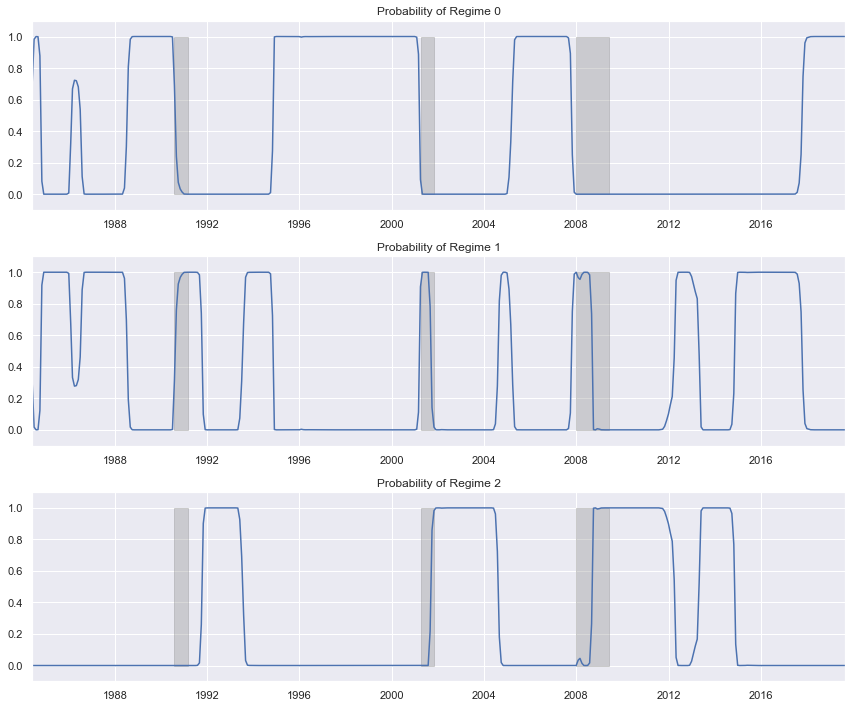

In [9]:
plot_Regime(res_hamilton, dta)

In [10]:
print(res_hamilton.expected_durations)

[31.61964528 15.86174219 27.17341797]


### Non Form Payroll

In [11]:
nfp = df2[['Dates', 'Non Farm Payroll']]
nfp2 = list(nfp['Non Farm Payroll'])
dta_nfp = pd.Series(nfp2, index=pd.date_range('1984-01-31', '2019-08-31', freq='M'))
print('p-value:',adfuller(dta_nfp)[1])

p-value: 0.00865921077462316


In [12]:
mod_nfp = sm.tsa.MarkovRegression(dta_nfp, k_regimes=3)
res_nfp = mod_nfp.fit()
res_nfp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  428
Model:               MarkovRegression   Log Likelihood               -2725.268
Date:                Sat, 18 Jan 2020   AIC                           5470.536
Time:                        18:20:30   BIC                           5511.127
Sample:                    01-31-1984   HQIC                          5486.567
                         - 08-31-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -169.9704     21.046     -8.076      0.000    -211.221    -128.720
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        156.5769     30.682      5.103      0.000      96.441     216.713
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        202.6708      7.736     26.197      0.000     187.508     217.834
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.721e+04   1208.024     14.244      0.000    1.48e+04    1.96e+04
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9293      0.044     21.085      0.000       0.843       1.016
p[1->0]     2.078e-12      0.289   7.18e-12      1.000      -0.567       0.567
p[2->0]        0.0147      0.008      1.870      0.062      -0.001       0.030
p[0->1]        0.0677      0.112      0.604      0.546      -0.152       0.287
p[1->1]     1.788e-63      0.383   4.66e-63      1.000      -0.752       0.752
p[2->1]     4.919e-35      0.030   1.65e-33      1.000      -0.058       0.058
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [13]:
prob_df(res_nfp,3)

,0,1,2,POS
1984-01-31,0.00000,0.00700,0.99300,2
1984-02-29,0.00000,0.00000,1.00000,2
1984-03-31,0.00000,0.00000,1.00000,2
1984-04-30,0.00000,0.00000,1.00000,2
1984-05-31,0.00000,0.00000,1.00000,2
...,...,...,...,...
2019-04-30,0.00003,0.00007,0.99991,2
2019-05-31,0.00042,0.00002,0.99956,2
2019-06-30,0.00005,0.00039,0.99956,2
2019-07-31,0.00005,0.00004,0.99991,2


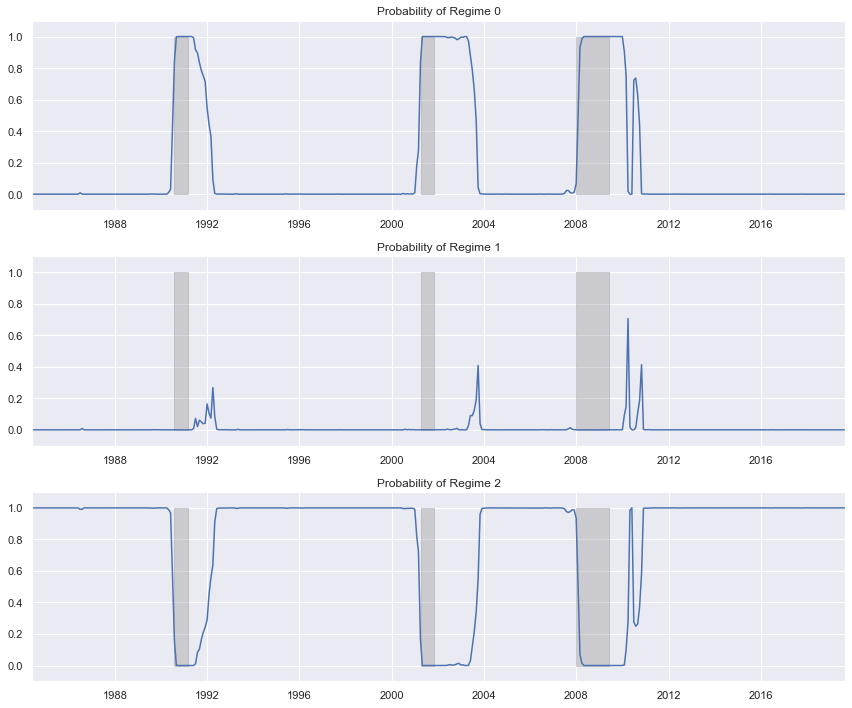

In [14]:
plot_Regime(res_nfp, dta_nfp)

In [15]:
print(res_nfp.expected_durations)

[14.14712037  1.         68.09051942]


### Labor Force Participation Index

In [16]:
gdp = df2[['Dates', 'GDP QOQ Index']]
gdp2= list(gdp['GDP QOQ Index'])
dta_gdp = pd.Series(gdp2, index=pd.date_range('1984-01-31', '2019-08-31', freq='M'))
print('p-value:', adfuller(dta_gdp)[1])

p-value: 0.0004485339914781109


In [17]:
mod_gdp = sm.tsa.MarkovRegression(dta_gdp, k_regimes=3)
res_gdp = mod_gdp.fit()
res_gdp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  428
Model:               MarkovRegression   Log Likelihood                -839.535
Date:                Sat, 18 Jan 2020   AIC                           1699.070
Time:                        18:20:32   BIC                           1739.661
Sample:                    01-31-1984   HQIC                          1715.101
                         - 08-31-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6197      0.270     -9.709      0.000      -3.149      -2.091
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2723      0.036     63.492      0.000       2.202       2.342
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9412        nan        nan        nan         nan         nan
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.7561      0.150     11.745      0.000       1.463       2.049
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7825      0.074     10.571      0.000       0.637       0.928
p[1->0]        0.0262      0.010      2.653      0.008       0.007       0.046
p[2->0]     6.925e-08        nan        nan        nan         nan         nan
p[0->1]        0.1857      0.071      2.606      0.009       0.046       0.325
p[1->1]        0.9138      0.020     44.596      0.000       0.874       0.954
p[2->1]        0.1175      0.032      3.630      0.000       0.054       0.181
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [18]:
prob_df(res_gdp,3)

,0,1,2,POS
1984-01-31,0.00000,0.00006,0.99994,2
1984-02-29,0.00000,0.00000,1.00000,2
1984-03-31,0.00000,0.00001,0.99999,2
1984-04-30,0.00000,0.00001,0.99999,2
1984-05-31,0.00000,0.00001,0.99999,2
...,...,...,...,...
2019-04-30,0.00000,0.99167,0.00833,1
2019-05-31,0.00000,0.99304,0.00695,1
2019-06-30,0.00001,0.99855,0.00143,1
2019-07-31,0.00001,0.99861,0.00138,1


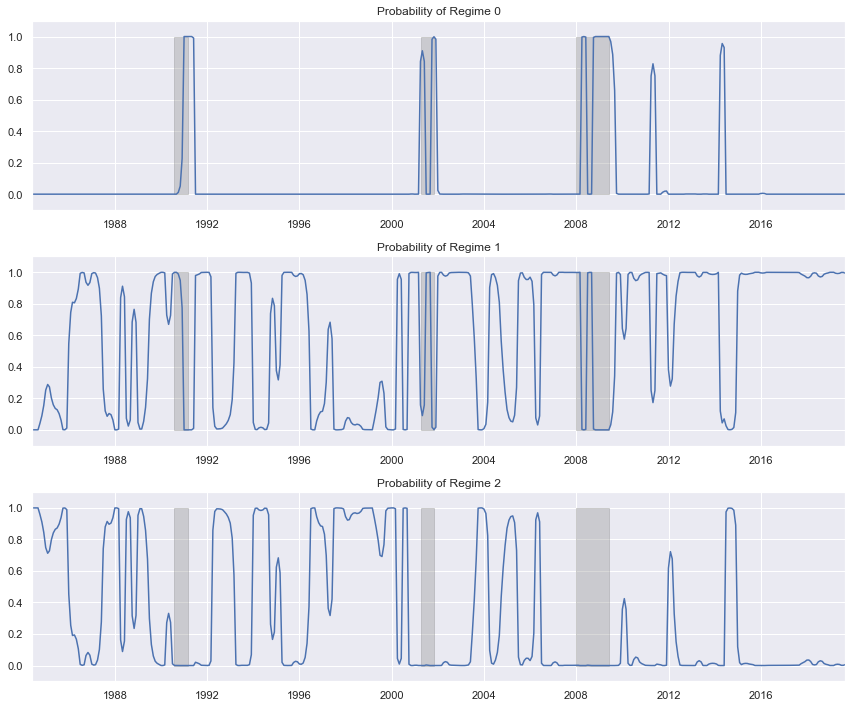

In [19]:
plot_Regime(res_gdp, dta_gdp)

In [20]:
print(res_gdp.expected_durations)

[ 4.59712479 11.60722274  8.50914681]
